## Import Packages

In [1]:
# import packages
# Importing all necessary packages

import numpy as np
import pandas as pd
#from sklearn.decomposition import PCA
import collections
from sklearn.model_selection import train_test_split

# importing os module
import os
import time
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import mutual_info_classif, SelectKBest

from sklearn.feature_selection import RFECV
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
import xgboost as xgb
from sklearn import svm
from sklearn.svm import SVC

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import roc_curve
from sklearn.metrics import RocCurveDisplay
from sklearn.feature_selection import SelectFromModel

from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score

from sklearn.impute import SimpleImputer
from sklearn.impute import KNNImputer
#import shap
import random
import seaborn as sns
import scipy
import warnings
warnings.filterwarnings("ignore")

## Functions

#### 1. Split Function: Splits the data into train and test

x: input

y:output

In [2]:
def split(x, y, random_state): # x and y are raw
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, shuffle=True, random_state=random_state)
    # data without imputation and target values
    return x_train, x_test, y_train, y_test # _0 retaines sample type information _1 are without sample type info

#### 2. Random Selection: randomly selects a set of n features

In [3]:
def random_selection(num, all_features, random_state):
    # num is the feature set size to be selected
    # all_features = total pool of features
    # random selection of columns
    random.seed(random_state)
    features = []
    features = random.sample(all_features, num)
    return features

3. Min-Max Scaling


In [4]:
def minmax_scaling(x_train, x_test):

    scaler = MinMaxScaler()
    scaler.fit(x_train)
    x_train = pd.DataFrame(scaler.transform(x_train), columns=x_train.columns, index=x_train.index)
    x_test = pd.DataFrame(scaler.transform(x_test), columns=x_test.columns, index=x_test.index)
    return x_train, x_test


In [5]:
def impute(x_train, x_test):
    imputer = KNNImputer(n_neighbors=5)
    imputer.fit(x_train)
    x_train = pd.DataFrame(imputer.transform(x_train), columns=x_train.columns, index=x_train.index)
    x_test = pd.DataFrame(imputer.transform(x_test), columns=x_test.columns, index=x_test.index)
    return x_train, x_test

Evaluation

In [6]:
def eval(y_true, y_pred):
    acc = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, pos_label = "Tumor")
    precision = precision_score(y_true,y_pred, pos_label = "Tumor")
    recall = recall_score(y_true, y_pred, pos_label = "Tumor")
    auc = roc_auc_score(y_true, y_pred)
    return acc, f1, precision, recall

#### Classification task

In [7]:
def classification_task(x_train, x_test, y_train, y_test, models, model_names, random_state):
        
        # accuracy dictionary
        accuracy_cv = {} # iteration over seeds
        accuracy_pred = {} # iteration over seeds
      
        i = 0
        for est in models: 
                model_name = model_names[i]
                i = i + 1
                est = est.fit(x_train, y_train)

                #  Stratified Cross validation
                cv = StratifiedKFold(n_splits=5, shuffle=True, random_state = random_state)
                y_pred_CV = cross_val_predict(est, x_train, y_train, cv=cv)               
                report_CV = classification_report(y_train, y_pred_CV, target_names=["Normal", "Tumor"], output_dict=True)
                acc = report_CV["accuracy"]
                accuracy_cv[model_name] = acc


                # prediction
                y_pred = est.predict(x_test)

                report = classification_report(y_test, y_pred, target_names=["Normal", "Tumor"], output_dict=True)
                acc = report["accuracy"]
                accuracy_pred[model_name] = acc
                # returns directory for models
        return accuracy_cv, accuracy_pred

### Feature Selection:Mutual Information

In [8]:
def get_miscores(X, y, random_state):
    mi_scores = mutual_info_classif(X, y, random_state=random_state)
    return mi_scores
def get_migenes(x, y, k, random_state):
    mi_df  = pd.DataFrame(columns=["gene", "MI_score"])
    mi_df["gene"] = x.columns
    random.seed(random_state)
    seeds = random.sample(range(0, 1000), 3)
    for seed in seeds: # you can increase the list of seeds
        mi_scores= get_miscores(x, y, random_state=seed)
        mi_df[seed] = mi_scores
        # Mi_score column is mean of all seeds
    mi_df["MI_score"] = mi_df.iloc[:, 1:4].mean(axis=1)

    mi_df = mi_df.sort_values(by="MI_score", ascending=False)
        
    top_1000_df = mi_df.head(k)
    top_genes_mi = mi_df["gene"].tolist()[:k]
    
    # returns the list and dataframe
    return top_genes_mi, top_1000_df 


### Feature Selection: RF-SelectFromModel

In [9]:
def RFSFM(x_train, x_test,y_train, y_test, random_state):
    # Using RandomForestClassifier as the estimator
    rf = RandomForestClassifier(n_estimators=500, random_state=random_state)
    # Using SelectFromModel to select top 100 features
    selector = SelectFromModel(rf, max_features=100, threshold="median")
    selector.fit(x_train, y_train)
    selected_features = x_train.columns[selector.get_support()]
    x_train_rf = x_train[selected_features]
    x_test_rf = x_test[selected_features]
    return x_train_rf, x_test_rf, selected_features

### Feature Selection: SVMRFE

In [10]:
def svm_rfe(x_train, y_train, features, random_state): # returns dataframe of features 
    # min = min numbers of features to be selected
    
    # cross validation to be used in RFECV
    cv = StratifiedKFold(n_splits = 5, shuffle = True, random_state = random_state)
    
    # using SVC estimator to check Features importance using RFE 
    svc = svm.SVC(kernel = "linear", random_state=random_state)
    # RFECV optimizes the minimum set of features needed for cassification task
    rfecv_SVM = RFECV(svc, min_features_to_select = 20, cv=cv, scoring='f1_weighted',  n_jobs=-1)
    fit_rfecv_SVM = rfecv_SVM.fit(x_train, y_train)
    
    RFECV_SVM_Top_Feat_df = pd.DataFrame({'Features': features, 'Selected': fit_rfecv_SVM.support_,
                                  'Rank': fit_rfecv_SVM.ranking_})
    RFECV_SVM_Top_Feat_df = RFECV_SVM_Top_Feat_df.sort_values(by = 'Rank')
 
    return RFECV_SVM_Top_Feat_df
    
    
    
    

#### Ploting ROC

In [11]:
# function to plot ROC curve
def roc(model_list, x_test, y_test):
    disp = RocCurveDisplay.from_estimator(model_list[0], x_test, y_test, pos_label='Tumor', name ="LogR", lw = 5)
    RocCurveDisplay.from_estimator(model_list[1], x_test, y_test, pos_label='Tumor', ax=disp.ax_, name ="RF", lw = 5);
    RocCurveDisplay.from_estimator(model_list[2], x_test, y_test, pos_label='Tumor', ax=disp.ax_, name ="MLP", lw = 5);
    RocCurveDisplay.from_estimator(model_list[3], x_test, y_test, pos_label='Tumor', ax=disp.ax_, name ="SVC", lw = 5); 
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.rc("font", size = 20)
    plt.legend(fontsize = "16", frameon = False)
    plt.title("100 genes (ANOVA)")
    plt.savefig("00-1_ROC_Top_100_Cancer.png", dpi=400, bbox_inches='tight')
    plt.show()


### Boxplot

In [12]:
def measure_boxplot(df_measure_imp, df_measure_random, filepath, title):
    df_imp_long = df_measure_imp.melt(var_name="Model", value_name="Accuracy")
    df_imp_long["Type"] = "Important"
    df_rand_long = df_measure_random.melt(var_name="Model", value_name="Accuracy")
    df_rand_long["Type"] = "Random"
    df_all = pd.concat([df_imp_long, df_rand_long], ignore_index= True)

    # calculating p-val
    p_cv_logr = float(scipy.stats.wilcoxon(df_measure_imp["LogR"], df_measure_random["LogR"],alternative = "greater")[1])
    #print(p_cv_logr)
    p_cv_RF = float(scipy.stats.wilcoxon(df_measure_imp["RF"], df_measure_random["RF"], alternative = "greater")[1])
    #print(p_cv_RF)
    p_cv_MLP = float(scipy.stats.wilcoxon(df_measure_imp["MLP"], df_measure_random["MLP"], alternative = "greater")[1])
    #print(p_cv_MLP)
    p_cv_SVC = float(scipy.stats.wilcoxon(df_measure_imp["SVC"], df_measure_random["SVC"], alternative = "greater")[1])
    #print(p_cv_SVC)
    pvals = {"LogR":p_cv_logr, "RF":p_cv_RF, "MLP":p_cv_MLP, "SVC": p_cv_SVC}
    plt.figure(figsize=(10,7))
    ax = sns.boxplot(x="Model", y="Accuracy", hue="Type", data=df_all, palette="Set2")

    # Add p-values above boxes
    for i, model in enumerate(df_all["Model"].unique()):
        y = df_all[df_all["Model"]==model]["Accuracy"].max() + 0.002  # position above box
        p = pvals[model]
        ax.text(i, y, f"p = {p:.3e}", ha="center", va="bottom", fontsize=10, color="black")

    plt.title(title)
    plt.ylabel("Accuracy")
    plt.legend(title="Gene Set")    
    plt.savefig(filepath, dpi = 400)


## MAIN

### Getting the data ready for the main process

In [12]:
data_df = pd.read_csv("data/processed/Proteomics_processed.csv", index_col=0)
print(data_df.shape)
x = data_df.drop(columns=["Sample_Type"])
y = data_df["Sample_Type"]


(172, 9659)


In [13]:
data_df.head(5)

,A1BG,A2M,A2ML1,AAAS,AACS,AADAC,AAED1,AAGAB,AAK1,AAMDC,...,ZSCAN18,ZSWIM8,ZW10,ZWILCH,ZXDC,ZYG11B,ZYX,ZZEF1,ZZZ3,Sample_Type
C3N-01858,28.995319,30.736379,29.040847,24.349255,24.835613,22.901014,NaN,24.350419,24.404310,24.653284,...,22.549447,24.874795,24.741568,22.474668,19.312808,22.574369,27.594966,24.716259,NaN,Normal
C3L-00997,28.603387,29.856150,28.953444,24.007908,25.429380,20.172090,NaN,24.408536,24.102491,26.070743,...,22.422195,25.118636,24.869126,22.319069,19.047789,22.734863,27.669626,24.672171,NaN,Normal
C3N-03849,29.747124,31.309474,27.664526,24.254423,24.757756,21.858144,NaN,24.190953,24.311839,25.586079,...,22.717747,24.980916,24.523857,22.277370,18.764842,22.976584,27.843381,24.647328,NaN,Normal
C3N-01859,29.002365,30.451296,28.925054,24.285946,25.090256,21.656457,19.038030,24.429677,24.198527,25.705912,...,NaN,24.751699,24.833425,22.397697,18.791202,22.980070,27.412686,24.612532,NaN,Normal
C3N-03933,29.462685,30.490461,28.327989,24.125763,24.496557,20.339912,19.371766,24.337448,24.230078,26.588817,...,NaN,24.649035,24.591532,22.136796,19.411112,23.439007,27.619972,24.746321,NaN,Normal


## MAIN LOOP -- Loops for 100 random states

In [14]:
# iteration of random seeds

# dictionaries to store results
# dict to store selected genes from MI and SVM-RFE
# dtaaframe to store results
dict_mi = {}
dict_svmrfe = {}
dict_rfsfm = {}
dict_acc_cv = {"LogR":[], "RF":[], "MLP":[], "SVC":[]}
dict_acc_pred = {"LogR":[], "RF":[], "MLP":[], "SVC":[]}
dict_acc_cv_random = {"LogR":[], "RF":[], "MLP":[], "SVC":[]}
dict_acc_pred_random = {"LogR":[], "RF":[], "MLP":[], "SVC":[]}
for i in range(100):
    random_state = i
    print("------------------------------------------------------------------")
    print("Iteration: ", i+1)
    print ("Random state: ", random_state)
    # train-test split
    x_train, x_test, y_train, y_test = split(x,y,random_state)

    # imputation of missing values
    x_train, x_test = impute(x_train, x_test)

    # Min-Max Scaling
    x_train, x_test = minmax_scaling(x_train, x_test)

    # Mutual Information based feature selection -- gives top 1000 genes
    top_genes_mi, top_1000_df = get_migenes(x_train, y_train, 1000, random_state)
    dict_mi[random_state] = top_genes_mi

    print("Top 1000 genes selected using MI")
   
    # updated x_train and x_test
    x_train_mi = x_train[top_genes_mi]
    x_test_mi = x_test[top_genes_mi]
    
    # Random forest based feature selection -- gives top 100 genes using SlectFromModel
    x_train_rfsfm, x_test_rfsfm, features_rfsfm = RFSFM(x_train_mi, x_test_mi, y_train, y_test, random_state)
    dict_rfsfm[random_state] = features_rfsfm.tolist()
    print("Top genes selected using RF-SelectFromModel: ", len(features_rfsfm))
    

    # SVM-RFE based feature selection -- gives top genes selected by SVM-RFE (not a fixed range)
    svm_rfe_df = svm_rfe(x_train_rfsfm, y_train, features_rfsfm, random_state) # returns dataframe of features (all features with selected True/False)

# selected features from SVM-RFE
    features_svmrfe = svm_rfe_df [svm_rfe_df['Selected'] == True]['Features'].tolist()
    dict_svmrfe[random_state] = features_svmrfe

    print("Top genes selected using SVM-RFE: ", len(features_svmrfe))

    # updated x_train and x_test
    x_train_svmrfe = x_train_rfsfm[features_svmrfe]
    x_test_svmrfe = x_test_rfsfm[features_svmrfe]

    # running 4 classifiers for evaltuion
    logr = LogisticRegression(random_state=random_state, max_iter=800, solver='liblinear')
    rf = RandomForestClassifier(random_state=random_state, n_estimators=500)
    mlp = MLPClassifier(random_state=random_state, max_iter=800, activation="relu", solver='lbfgs', alpha=1e-5)
    svc = SVC(random_state=random_state, kernel = "linear", C = 0.1)


    models = [logr, rf, mlp, svc]
    model_names = ["LogR", "RF", "MLP", "SVC"]

    # returns dictionary for models
    acc_cv, acc_pred = classification_task(x_train_svmrfe, x_test_svmrfe, y_train, y_test, models, model_names, random_state)    
    for key in acc_cv.keys():
        dict_acc_cv[key].append(acc_cv[key])
    for key in acc_pred.keys():
        dict_acc_pred[key].append(acc_pred[key])
        print(f"Accuracy for mode {key}: {acc_pred[key]}")

    print("Classification task using SVM-RFE selected genes done")

# random features for comparison

    num_features = len(features_svmrfe)
    all_features = x.columns.tolist()
    random_features = random_selection(num_features, all_features, random_state)
    x_train_random = x_train[random_features]
    x_test_random = x_test[random_features]

    # classification task
    acc_cv, acc_pred = classification_task(x_train_random, x_test_random, y_train, y_test, models, model_names, random_state)    
    for key in acc_cv.keys():
        dict_acc_cv_random[key].append(acc_cv[key])
    for key in acc_pred.keys():
        dict_acc_pred_random[key].append(acc_pred[key])
        print(f"Accuracy for mode {key}: {acc_pred[key]}")

    print("Classification task using Randomly selected genes done")





------------------------------------------------------------------
Iteration:  1
Random state:  0
Top 1000 genes selected using MI
Top genes selected using RF-SelectFromModel:  100
Top genes selected using SVM-RFE:  20
Accuracy for mode LogR: 1.0
Accuracy for mode RF: 1.0
Accuracy for mode MLP: 1.0
Accuracy for mode SVC: 1.0
Classification task using SVM-RFE selected genes done
Accuracy for mode LogR: 0.8857142857142857
Accuracy for mode RF: 0.9142857142857143
Accuracy for mode MLP: 0.8285714285714286
Accuracy for mode SVC: 0.8285714285714286
Classification task using Randomly selected genes done
------------------------------------------------------------------
Iteration:  2
Random state:  1
Top 1000 genes selected using MI
Top genes selected using RF-SelectFromModel:  100
Top genes selected using SVM-RFE:  20
Accuracy for mode LogR: 1.0
Accuracy for mode RF: 1.0
Accuracy for mode MLP: 1.0
Accuracy for mode SVC: 1.0
Classification task using SVM-RFE selected genes done
Accuracy for mo

In [15]:
# saving results

#-----genes--------------
# MI selected genes --fixed number 1000
df_mi_df = pd.DataFrame()
for key in dict_mi.keys():
    df_mi_df[key] = dict_mi[key]
df_mi_df.to_csv("results/SO/P/00-1_Top_1000_genes_MI_P.csv")

#RFSFM Selected genes -- number can vary 
df_rfsfm = pd.DataFrame()
for key in dict_rfsfm.keys():
    df_rfsfm[key] = [dict_rfsfm[key]]
df_rfsfm.to_csv("results/SO/P/00-1_Top_genes_RFSFM_P.csv")

# SVMRFE selected gene -- number can vary
df_svmrfe = pd.DataFrame()
for key in dict_svmrfe.keys():
    df_svmrfe[key] = [dict_svmrfe[key]]
df_svmrfe.to_csv("results/SO/P/00-1_Top_genes_SVMRFE_P.csv") 


#-------performance measures -------------

# Cross validation SVMRFE
df_acc_cv = pd.DataFrame(dict_acc_cv)
df_acc_cv.to_csv("results/SO/P/00-1_Accuracy_CV_SVMRFE_P.csv")

# Test SVMRFE
df_acc_pred = pd.DataFrame(dict_acc_pred)
df_acc_pred.to_csv("results/SO/P/00-1_Accuracy_Pred_SVMRFE_P.csv")

# Cross Validation Random
df_acc_cv_random = pd.DataFrame(dict_acc_cv_random)
df_acc_cv_random.to_csv("results/SO/P/00-1_Accuracy_CV_Random_P.csv")

# Test Random
df_acc_pred_random = pd.DataFrame(dict_acc_pred_random)
df_acc_pred_random.to_csv("results/SO/P/00-1_Accuracy_Pred_Random_P.csv")

## FINAL results over selected gene set

### SVMRFE

In [17]:
# finding the most reoccuring top 10 genes from SVMRFE
num = []
dict_gene_freq = {}

for key in dict_svmrfe.keys():
    num.append(len(dict_svmrfe[key]))
    for gene in dict_svmrfe[key]:
        if gene in dict_gene_freq:
            dict_gene_freq[gene] += 1
        else:
            dict_gene_freq[gene] = 1

In [19]:
len(dict_svmrfe), len(num)

(100, 100)

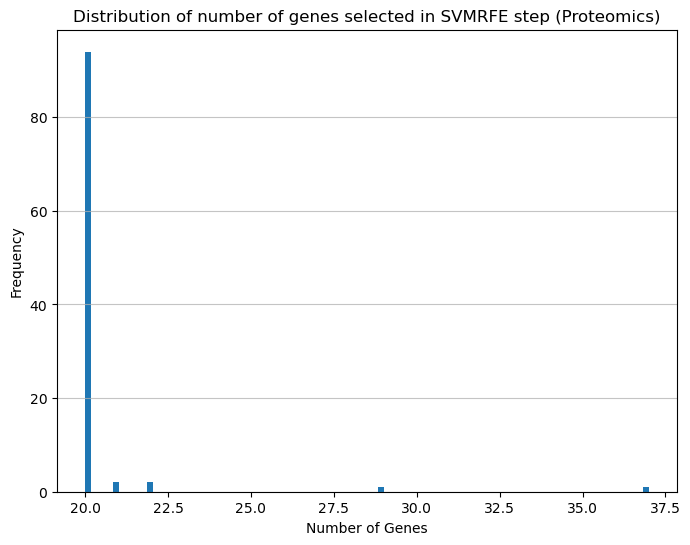

In [21]:
# histogram
plt.figure(figsize=(8,6))
plt.hist(num, bins = 100)
plt.title('Distribution of number of genes selected in SVMRFE step (Proteomics)')
plt.xlabel('Number of Genes', fontsize=10)
plt.ylabel('Frequency', fontsize=10)
plt.grid(axis='y', alpha=0.75)
plt.show()


In [ ]:
df_gene_freq = pd.DataFrame.from_dict(dict_gene_freq, orient="index")
df_gene_freq_svmrfe = df_gene_freq.sort_values(by = 0, ascending = False)
df_gene_freq_svmrfe.to_csv("results/SO/P/00-1_SVMRFE_GENEFreq_P.csv")
df_gene_freq_svmrfe.head(20)

,0
ADH4,97
SH3BGRL2,90
SCIN,78
PID1,73
CYP4F12,69
ADAR,67
HPX,66
CAVIN2,61
KRT13,61
C2orf54,60


### RFSFM

In [ ]:

num = []
dict_gene_freq = {}

for key in dict_rfsfm.keys():
    num.append(len(dict_rfsfm[key]))
    for gene in dict_rfsfm[key]:
        if gene in dict_gene_freq:
            dict_gene_freq[gene] += 1
        else:
            dict_gene_freq[gene] = 1

In [25]:
len(dict_svmrfe), len(num)

(100, 100)

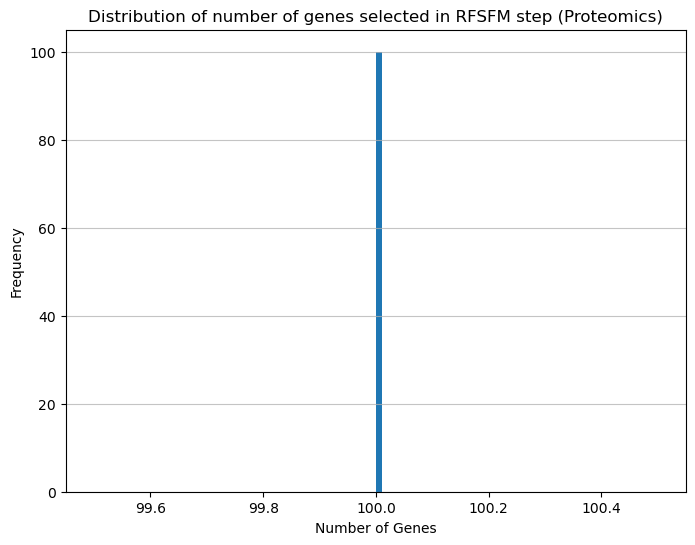

In [26]:
# histogram
plt.figure(figsize=(8,6))
plt.hist(num, bins = 100)
plt.title('Distribution of number of genes selected in RFSFM step (Proteomics)')
plt.xlabel('Number of Genes', fontsize=10)
plt.ylabel('Frequency', fontsize=10)
plt.grid(axis='y', alpha=0.75)
plt.show()


In [27]:
df_gene_freq = pd.DataFrame.from_dict(dict_gene_freq, orient= "index")
df_gene_freq_svmrfe = df_gene_freq.sort_values(by = 0, ascending = False)
df_gene_freq_svmrfe.to_csv("results/SO/P/00-1_RFSFM_GENEFreq_P.csv")
df_gene_freq_svmrfe.head(20)

,0
AKAP12,100
SH3BGRL2,100
CAB39L,100
DCN,100
EHD2,100
OGN,100
LYVE1,100
CAVIN2,100
SPTAN1,100
CAVIN1,100


### MI

In [ ]:

dict_gene_freq = {}

for key in dict_mi.keys():
    
    for gene in dict_mi[key]:
        if gene in dict_gene_freq:
            dict_gene_freq[gene] += 1
        else:
            dict_gene_freq[gene] = 1
len(dict_mi)

(100, 100)

In [39]:
df_gene_freq = pd.DataFrame.from_dict(dict_gene_freq, orient= "index")
df_gene_freq_svmrfe = df_gene_freq.sort_values(by = 0, ascending = False)
df_gene_freq_svmrfe.to_csv("results/SO/P/00-1_MI_GENEFreq_P.csv")


### Boxplot

In [13]:
df_acc_cv = pd.read_csv("results/SO/P/00-1_Accuracy_CV_SVMRFE_P.csv", index_col = 0)
df_acc_cv_random = pd.read_csv("results/SO/P/00-1_Accuracy_CV_Random_P.csv", index_col = 0)
df_acc_pred = pd.read_csv("results/SO/P/00-1_Accuracy_Pred_SVMRFE_P.csv", index_col = 0)
df_acc_pred_random = pd.read_csv("results/SO/P/00-1_Accuracy_Pred_Random_P.csv", index_col =0 )

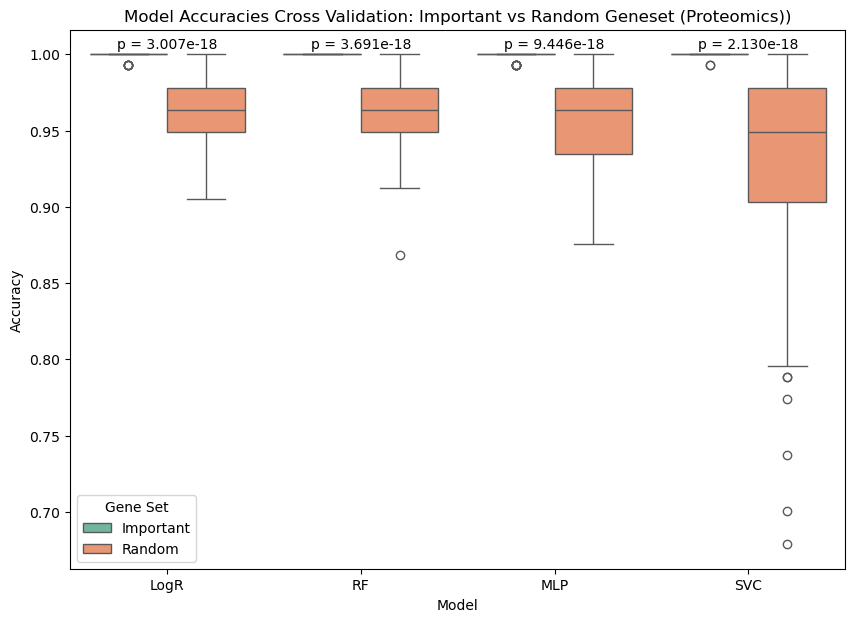

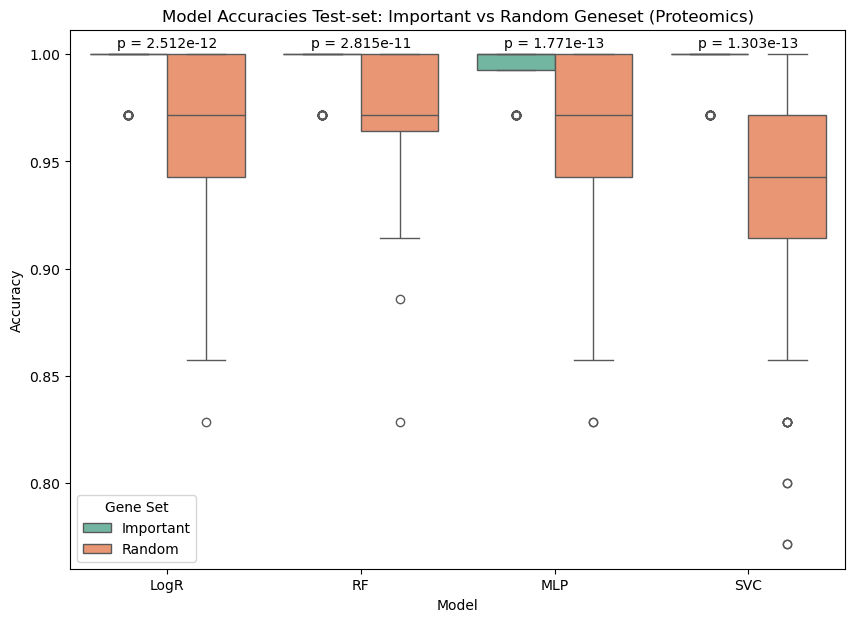

In [14]:
filepath = "results/SO/P/00-1_Fig_Acc_CV_P.jpeg"
title = "Model Accuracies Cross Validation: Important vs Random Geneset (Proteomics))"
measure_boxplot(df_acc_cv, df_acc_cv_random, filepath, title)
filepath = "results/SO/P/00-1_Fig_Acc_pred_P.jpeg"
title = "Model Accuracies Test-set: Important vs Random Geneset (Proteomics)"
measure_boxplot(df_acc_pred, df_acc_pred_random, filepath, title)


## FINAL CLASSIFICATION TASK ON SELECTED TOP 20

1. classification using LogR, RF, GB, SVC, MLP

2. can we build network to capture feature relations among themselves using the feature importance values?

3. As a evalulation report -- accuracy, recall, f1, precision, auc